# **Factorization Machine**
- breast cancer data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# data : breast_cancer(30개의 변수를 기반으로 암 발생여부 예측)
from sklearn.datasets import load_breast_cancer
file = load_breast_cancer()
X, Y = file['data'], file['target']

# scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [9]:
n = X.shape[0] # 569
p = X.shape[1] # 30(예측변수 개수)
k = 10 # 잠재변수 개수
batch_size = 8
epochs = 10

### FM Modeling
(Not recommendation)

In [10]:
class FM(tf.keras.Model):
  def __init__(self):
    super(FM, self).__init__()

    # parameter
    self.w0 = tf.Variable([0.0])
    self.w = tf.Variable(tf.zeros([p]))
    self.V = tf.Variable(tf.random.normal(shape=(p, k)))
  
  # 방정식 구현
  def call(self, inputs):
    # 선형결합
    linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1) # input(x)와 w를 곱해 시그마

    # interactions(논문의 재표현된 식 사용)
    interactions = 0.5 * tf.reduce_sum(
        tf.math.pow(tf.matmul(inputs, self.V), 2) 
        - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)), 1, keepdims=False 
        # matmul : 3차원 텐서사이의 행렬 곱
    )

    # 선형 방정식 : sigmoid 사용
    y_hat = tf.math.sigmoid(self.w0 + linear_terms + interactions)
    return y_hat

In [11]:
# Forward
def train_on_batch(model, optimizer, accuracy, inputs, targets):
    with tf.GradientTape() as tape:
        y_pred = model(inputs)
        # loss = cross entropy(이진 분류)
        loss = tf.keras.losses.binary_crossentropy(from_logits=False,
                                                   y_true=targets,
                                                   y_pred=y_pred)
    # loss를 파라미터로 편미분해 gradient를 구함
    grads = tape.gradient(target=loss, sources=model.trainable_variables)
    # apply_gradients()를 통해 processed gradients를 적용
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # accuracy: update할 때마다 정확도는 누적 업데이트 
    accuracy.update_state(targets, y_pred)

    return loss


# 반복 학습 함수
def train(epochs):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

    train_ds = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_train, tf.float32), tf.cast(Y_train, tf.float32))).shuffle(500).batch(8)

    test_ds = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_test, tf.float32), tf.cast(Y_test, tf.float32))).shuffle(200).batch(8)

    model = FM()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01) # SGD 사용
    accuracy = BinaryAccuracy(threshold=0.5)
    loss_history = []

    for i in range(epochs):
      for x, y in train_ds:
          loss = train_on_batch(model, optimizer, accuracy, x, y)
          loss_history.append(loss)

      if i % 2== 0:
          print("스텝 {:03d}에서 누적 평균 손실: {:.4f}".format(i, np.mean(loss_history)))
          print("스텝 {:03d}에서 누적 정확도: {:.4f}".format(i, accuracy.result().numpy()))


    test_accuracy = BinaryAccuracy(threshold=0.5)
    for x, y in test_ds:
        y_pred = model(x)
        test_accuracy.update_state(y, y_pred)

    print("테스트 정확도: {:.4f}".format(test_accuracy.result().numpy()))

In [12]:
# epoch = 50
train(30)

스텝 000에서 누적 평균 손실: 1.1700
스텝 000에서 누적 정확도: 0.4906
스텝 002에서 누적 평균 손실: 0.7489
스텝 002에서 누적 정확도: 0.6933
스텝 004에서 누적 평균 손실: 0.6140
스텝 004에서 누적 정확도: 0.7585
스텝 006에서 누적 평균 손실: 0.5396
스텝 006에서 누적 정확도: 0.7933
스텝 008에서 누적 평균 손실: 0.4900
스텝 008에서 누적 정확도: 0.8161
스텝 010에서 누적 평균 손실: 0.4539
스텝 010에서 누적 정확도: 0.8325
스텝 012에서 누적 평균 손실: 0.4259
스텝 012에서 누적 정확도: 0.8453
스텝 014에서 누적 평균 손실: 0.4034
스텝 014에서 누적 정확도: 0.8556
스텝 016에서 누적 평균 손실: 0.3847
스텝 016에서 누적 정확도: 0.8636
스텝 018에서 누적 평균 손실: 0.3688
스텝 018에서 누적 정확도: 0.8701
스텝 020에서 누적 평균 손실: 0.3551
스텝 020에서 누적 정확도: 0.8757
스텝 022에서 누적 평균 손실: 0.3430
스텝 022에서 누적 정확도: 0.8808
스텝 024에서 누적 평균 손실: 0.3323
스텝 024에서 누적 정확도: 0.8852
스텝 026에서 누적 평균 손실: 0.3227
스텝 026에서 누적 정확도: 0.8889
스텝 028에서 누적 평균 손실: 0.3140
스텝 028에서 누적 정확도: 0.8924
테스트 정확도: 0.9417


## Feature vectorize
- **sklearn.feature_extraction.DictVectorize**    
: dict을 array나 sparse matrix로 변환해줌. 문자열은 one-hot encoding.     



In [13]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False) # sparse = True : sparse matrix로 반환
dic = [ {'daeun':1, 'jungmin':2}, {'kihong':3, 'boaz':2}]
X = v.fit_transform(dic)
X   # 2*4 array 반환, abcd 순서

array([[0., 1., 2., 0.],
       [2., 0., 0., 3.]])

In [14]:
v.inverse_transform(X) # 다시 dict으로 바꿔줌

[{'daeun': 1.0, 'jungmin': 2.0}, {'boaz': 2.0, 'kihong': 3.0}]

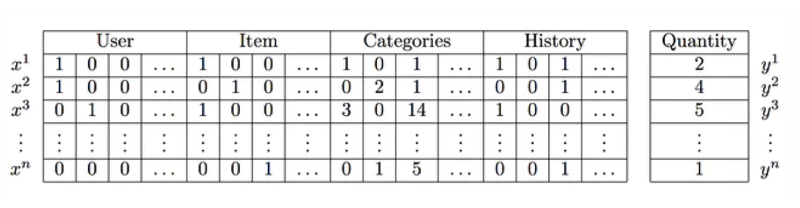

# **Modeling with movielens**

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
# load data
ratings = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/추천스터디/ratings.dat', names=['userId', 'movieId', 'rating', 'time'], delimiter='::', engine='python')
ratings.drop('time', axis=1, inplace=True)
movies = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/추천스터디/movies.dat', names=['MovieId', 'Title', 'Genres'], delimiter='::', engine='python')
users = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/추천스터디/users.dat', names=['UserId', 'Gender', 'Age', 'Occupation', 'Zip-code'], delimiter='::', engine='python')

In [19]:
ratings.head(2)

,userId,movieId,rating
0,1,1193,5
1,1,661,3


In [20]:
movies.head(2)

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [21]:
users.head(2)

,UserId,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072


In [22]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Unique한 user의 수 : {}'.format(n_users))
print('Unique한 movie의 수 : {}'.format(n_movies))

Unique한 user의 수 : 6040
Unique한 movie의 수 : 3706


## LightFM
- popular recomendation algorithms for both implicit and explicit feedback.
- possible to incorporate both item and user metadata into the traditional matrix factorization algorithms.
- It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features).
- http://lyst.github.io/lightfm/docs/index.html

In [29]:
!pip install lightfm

     |████████████████████████████████| 307kB 2.7MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707640 sha256=85c89f6fdf3beb9033715f89235271b80df4758ad2de09b38c354cc5d8974c12
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [34]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split

import pandas as pd
import numpy as np
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

In [38]:
# item_info
movies.head(2)

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [39]:
# user_info
users.head(2)

,UserId,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072


In [40]:
# rating (explicit)
ratings.head(2)

,userId,movieId,rating
0,1,1193,5
1,1,661,3


In [52]:
print(movies.shape, users.shape, ratings.shape)

(3883, 3) (6040, 5) (1000209, 3)


### Transform Data

In [70]:
# User & Item feature를 추가하기 위해 아래와 같은 형식으로 지정
user_info = (
    users['UserId'], 
    users['Gender'],
    users['Age'],
    users['Occupation'],
    users['Zip-code'],
)

item_info = (
    movies['MovieId'],
    movies['Title'], 
    movies['Genres'],
)

In [71]:
def build_features(ftype, dataset, features):
    
    uf = []

    for r in range(len(features[0])):
        uf1 = []
        for c in range(1, len(features)):
            uf1.append(features[c].iloc[r])
        uf.append((features[0].iloc[r], uf1))    

    for c in range(1, len(features)):
        if ftype == 'user':
            dataset.fit_partial(users=features[0], user_features=features[c])
        else:
            dataset.fit_partial(items=features[0], item_features=features[c])  

    if ftype == 'user':
        return dataset.build_user_features(uf)
    else:
        return dataset.build_item_features(uf)   

In [72]:
ds = Dataset()

# 1. Specify user_ids & item_ids
ds.fit(users=users['UserId'], items=movies['MovieId'])

# 2. Build Interaction Matrix (like ratings matrix)
interactions, weights = ds.build_interactions( [ (i, j) for i, j in zip(ratings['userId'], ratings['movieId'])])

In [73]:
user_info[0]

0          1
1          2
2          3
3          4
4          5
        ... 
6035    6036
6036    6037
6037    6038
6038    6039
6039    6040
Name: UserId, Length: 6040, dtype: int64

In [62]:
len(user_info)

5

In [74]:
## side info
# 3. Build user feature & item features
user_features = build_features('user', ds, user_info)
item_features = build_features('item', ds, item_info)

In [76]:
user_features

<6040x9482 sparse matrix of type '<class 'numpy.float32'>'
	with 30182 stored elements in Compressed Sparse Row format>

### split data

In [77]:
train, test = random_train_test_split(interactions, test_percentage=0.25, random_state=np.random.RandomState(123))

In [78]:
train

<6040x3883 sparse matrix of type '<class 'numpy.int32'>'
	with 750156 stored elements in COOrdinate format>

In [79]:
m1 = LightFM(loss='warp', random_state=123)  # Refer to LightFM API
%time m1.fit(train)
m2 = LightFM(loss='warp', random_state=123)  # Refer to LightFM API
%time m2.fit(train, user_features=user_features, item_features=item_features)

CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 796 ms
CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.49 s


In [81]:
# Compute precision, recall & f1-score
def precision_recall_score(model, data, user_features, item_features, k):
    precision = precision_at_k(model, data, user_features=user_features, item_features=item_features, k=k).mean()
    recall = recall_at_k(model, data, user_features=user_features, item_features=item_features, k=k).mean()
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

%time print(precision_recall_score(m1, test, user_features=None, item_features=None, k=10))
%time print(precision_recall_score(m2, test, user_features=user_features, item_features=item_features, k=10))

(0.12856434, 0.05038025863413966, 0.07239229113683172)
CPU times: user 4.85 s, sys: 0 ns, total: 4.85 s
Wall time: 4.85 s
(0.119158804, 0.0454548159747065, 0.0658067238135946)
CPU times: user 5.54 s, sys: 0 ns, total: 5.54 s
Wall time: 5.54 s


### Recommend top_N items

In [82]:
# Recommend top-N items for each user
def make_recommendation(model, dataset, user_features, item_features, n_users, k):
    n_items = dataset.interactions_shape()[1]
    recs = []
    for user_id in range(n_users):
        scores = model.predict(user_id, np.arange(n_items), user_features=user_features, item_features=item_features)
        top_items = np.argsort(-scores)[:k]      
        rec = [list(dataset.mapping()[2].keys())[i] for i in top_items]
        recs.append(rec)
    recs = pd.DataFrame(pd.DataFrame(recs, index=list(dataset.mapping()[0].keys())[:n_users]).stack()).reset_index(). \
                    rename({'level_0':'user_id', 'level_1': 'rank', 0: 'item_id'}, axis=1).iloc[:,[0,2,1]]
    return recs    

%time make_recommendation(m2, ds, user_features=user_features, item_features=item_features, n_users=1000, k=10)

CPU times: user 1.2 s, sys: 262 µs, total: 1.2 s
Wall time: 1.21 s


,user_id,item_id,rank
0,1,2396,0
1,1,2858,1
2,1,1265,2
3,1,1307,3
4,1,260,4
...,...,...,...
9995,1000,1307,5
9996,1000,593,6
9997,1000,608,7
9998,1000,356,8


#### cf 1. lightfm 내장 데이터셋 이용


In [84]:
import numpy as np
from lightfm.datasets import fetch_movielens

data = fetch_movielens()

In [85]:
data

{'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>}

In [86]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [87]:
train = movielens['train']
test = movielens['test']

In [88]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.60, test 0.10.
AUC: train 0.89, test 0.86.


In [89]:
def sample_recommendation(model, data, user_ids):


    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:3]:
            print("        %s" % x)

sample_recommendation(model, data, [3, 25, 450])

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Contact (1997)
        Air Force One (1997)
        Scream (1996)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Scream (1996)
        Devil's Own, The (1997)
        Dante's Peak (1997)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        English Patient, The (1996)
        Cop Land (1997)
        Seven Years in Tibet (1997)


### cf2. FM Function 직접생성


In [ ]:
# subset data 생성
def subsetdata(data, by, subset_quantile):
  filter_standard = data.groupby([by]).size().reset_index(name='counts').counts.quantile(subset_quantile)
  subset_data = data.groupby([by]).filter(lambda x : len(x) >= filter_standard)
  return filter_standard, subset_data

# split train and test data
def split_testtrain(ratings, fraction):
    #Transform data in matrix format
    colnames = ratings.columns.values
    new_colnames = ["1_user", "2_movie", "0_rating"]
    ratings = ratings.rename(index=str, columns=dict(zip(colnames, new_colnames)))
    
    ratings_df = ratings.to_dict(orient="records")
    
    dv = DictVectorizer()
    ratings_mat = dv.fit_transform(ratings_df).toarray()
    
    #Split data
    x_train, x_test, y_train, y_test = train_test_split(ratings_mat[:,1:], ratings_mat[:,:1], test_size=fraction)
    
    return x_train, x_test, y_train.T[0], y_test.T[0]

#One hot encoding
def OneHotEncoding(train,test):
    encoder = OneHotEncoder(handle_unknown='ignore').fit(train)
    train = encoder.transform(train)
    test = encoder.transform(test)
    return train, test

#Gridsearch for the optimal parameter
def param_selection(X, y, n_folds):
    start = time.time()
    grid_param = {  
    'n_iter' : np.arange(0,120,25)[1:],
    'rank' :  np.arange(2,12,4),
    }
    grid_search = GridSearchCV(als.FMRegression(l2_reg_w=0.1,l2_reg_V=0.1), cv=n_folds, param_grid=grid_param, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    print(time.time()-start)
    return grid_search.best_params_

def rec_coverage(x_test, y_test, prediction, rec_num):
    ratings = pd.DataFrame()
    ratings['user'] = x_test[:,0]
    ratings['movie'] = x_test[:,1]
    ratings['rating'] = y_test
    
    pred = ratings.copy()
    pred['rating'] = prediction
    
    rating_table = pd.pivot_table(ratings, index='user', columns = 'movie', values = 'rating')
    pred_table = pd.pivot_table(pred, index='user', columns = 'movie', values = 'rating')
    
    rec_movies = []
    rec = pred_table - rating_table
    for user in rec.index:
            rec_item = pred_table.loc[user,:].sort_values(ascending = False).head(rec_num).index.tolist()
            rec_movies += rec_item
    n_rec = len(set(rec_movies))
    n_movies = pred_table.shape[1]
    coverage = round(float(n_rec)/n_movies,2)
    
    return coverage

def FactorizationMachine(ratings, subset_by, subset_quantile):
    #Initialize output
    final_output = pd.DataFrame()
    result_dict = []
    n_iteration = 1 
    last_RMSE = 100
    threshold = 0
    
    for quantile in subset_quantile:
        print("---Running iteration " + str(n_iteration) + " ---")
        print("---Subsetting Original Data---")
        #subset original data
        if subset_by == "user":
            filter_standard, subset_ratings = subsetdata(ratings, "userId", quantile)
        elif subset_by == "movie":
            filter_standard, subset_ratings = subsetdata(ratings, "movieId", quantile)
        else:
            f1, subset_u = subsetdata(ratings, "userId", quantile)
            f2, subset_ratings = subsetdata(subset_u, "movieId", quantile)
            filter_standard = "("+str(f1)+","+str(f2)+")"
            
        n_users = subset_ratings.userId.unique().shape[0]
        n_movies = subset_ratings.movieId.unique().shape[0]
        n_size = subset_ratings.shape[0]*subset_ratings.shape[1]
        
        sparsity = round(float(subset_ratings.shape[0]) / float(n_users*n_movies),2)
        
        print("---Spliting Test and Train Data---")
        #split test and train data
        xtrain, xtest, ytrain, ytest = split_testtrain(subset_ratings, 0.2)

        print("---Encoding Data---")
        #encode data
        xtrain_enc, xtest_enc = OneHotEncoding(xtrain, xtest)

        print("---Hyperparameter Tuning---")
        #Find the optimal parameter by hyperparameter tuning
        start = time.time()
        params = param_selection(xtrain_enc, ytrain, 3)
        op_iter = params['n_iter']
        op_rank = params['rank']
        
        print("---Factorization Machine---")
        #Factorization machine
        fm = als.FMRegression(n_iter=op_iter, rank=op_rank, l2_reg_w=0.1, l2_reg_V=0.1)
        fm.fit(xtrain_enc, ytrain)
        predictions = fm.predict(xtest_enc)
        spent_time = time.time() - start
        #Evaluation metrics
        rmse = sqrt(mean_squared_error(ytest,predictions))
        mae = mean_absolute_error(ytest,predictions)
        coverage = rec_coverage(xtest, ytest, predictions, 10)
        
        if rmse < last_RMSE:
            last_RMSE = rmse
            threshold = filter_standard
            out = pd.DataFrame()
            out['user'] = xtest[:,0]
            out['movie'] = xtest[:,1]
            out['rating'] = ytest
            out['prediction'] = predictions
            
            final_output = out.copy()
            
        result_dict.append([quantile, filter_standard, n_size, n_users, n_movies, sparsity, op_iter, op_rank, spent_time, mae, rmse, coverage])
        n_iteration += 1
    
    results = pd.DataFrame(result_dict)
    results.columns = ["Quantile", "Threshold", "Size", "Num_Users", "Num_Movies", "Sparsity", "OP_Iter", "OP_Rank", "Running Time", "MAE", "RMSE", "Coverage"]
    
    final_output.to_csv("FM_Output_"+subset_by+"_"+str(threshold)+".csv", sep=',', encoding='utf-8', index=False)
    
    return results

# **Appendix. Surprise 모듈을 이용한 추천**
<Surprise 추천 알고리즘 클래스>
- SVD 
- KNN
- BaselineOnly : user, item bias 고려
> +) Cross validate, GridSearch도 제공


In [92]:
!pip install surprise

In [95]:
import surprise
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = surprise.Dataset.load_builtin('ml-100k') # DatasetAutoFolds load

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [97]:
data # DatasetAutoFolds

In [110]:
# baseline : bias 추가
from surprise.model_selection import KFold
np.random.seed(0)

bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

acc = np.zeros(3)
cv = KFold(3)
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


In [124]:
# SVD
trainset = data.build_full_trainset()
algo = surprise.SVD(n_epochs=20, n_factors=50, random_state=2020)
algo.fit(trainset)
predictions = algo.test(testset)
surprise.accuracy.rmse(predictions)

RMSE: 0.7716


0.7715991639325044

In [121]:
# cross_validation 추가
algo_cv = surprise.SVD(n_factors=200, n_epochs=30)
print(cross_validate(algo, data))

{'test_rmse': array([0.93194071, 0.94194062, 0.92772369, 0.93601591, 0.93788744]), 'test_mae': array([0.73607189, 0.74390987, 0.72981601, 0.73829658, 0.73856838]), 'fit_time': (2.923640489578247, 2.8834123611450195, 2.896371364593506, 2.902172803878784, 2.8889548778533936), 'test_time': (0.30857133865356445, 0.15729999542236328, 0.1500396728515625, 0.15418171882629395, 0.14963960647583008)}


In [123]:
# 여러 모듈 사용
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate # surprise 전용 cv

benchmark = []
for algorithm in [SVD(), NMF(), KNNBaseline(), BaselineOnly()]:
    
    # cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.936344,0.286643,5.882109
SVD,0.944902,3.891357,0.375571
BaselineOnly,0.947462,0.096438,0.229139
NMF,0.977116,3.971769,0.263017
